In [7]:
import os
import sys
import time
import torch
from torch import nn
from torch.nn.parameter import Parameter
import math
import numpy as np
import scipy.sparse as sp
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import f1_score, roc_curve, auc

In [8]:
# 将节点标签从字符串类型转换为整型索引
def encode_labels(labels):
    classes = sorted(list(set(labels)))
    label2index = {label: idx for idx, label in enumerate(classes)}
    indices = [label2index[label] for label in labels]
    indices = np.array(indices, dtype=np.int32)
    return indices

In [9]:
# 建立无向图，不关注谁引用谁，只关注是否有关系，只要有关系就是1
# 使得邻接矩阵是对称的
def build_symmetric_adj(edges, node_num):
    adj = np.zeros((node_num, node_num), dtype=np.float32)
    for i, j in edges:
        # 无向图，所以两个方向都要有边
        adj[i][j] = 1
        adj[j][i] = 1
    for i in range(node_num):
        adj[i][i] = 1 # 自己到自己的边
    return adj

# 使图变成对称的，即使得邻接矩阵是对称的，增强了繁华想

In [10]:
# 归一化特征矩阵
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = np.diag(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [11]:
# 将邻接矩阵转换为稀疏矩阵
def adj_to_sparse_tensor(adj):
    adj = sp.coo_matrix(adj)
    indices = torch.from_numpy(
        np.vstack((adj.row, adj.col)).astype(np.int64)
    ).long()
    values = torch.from_numpy(adj.data).float()
    shape = torch.Size(adj.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [12]:
# 读取Cora数据集
def load_cora_data(data_path):
    print('Loading cora data...')
    # 使用np.genfromtxt读取数据得到一个content数组
    content = np.genfromtxt(os.path.join(data_path, 'cora.content'), dtype=np.dtype(str))
    idx = content[:, 0].astype(np.int32) # 节点id
    features = content[:, 1:-1].astype(np.float32) # 节点的特征向量
    # 将节点标签从字符串类型转换为整型索引
    labels = encode_labels(content[:, -1]) # 节点标签
    node_num = len(idx)
    print(f"node_num: {node_num}")
    # 读取Cora的边数据建立邻接矩阵
    cites = np.genfromtxt(os.path.join(data_path, 'cora.cites'), dtype=np.int32)
    # 将节点的ID映射到索引
    idx_map = {j: i for i, j in enumerate(idx)}
    print(f"idx_map: {idx_map}")
    edges = [(idx_map[i], idx_map[j]) for i, j in cites] # 边的列表
    edges = np.array(edges, dtype=np.int32)
    print(f"edges_num: {len(edges)}")
    # 建立cora对应的无向图adj
    adj = build_symmetric_adj(edges, node_num)
    print(f"adj: {adj.shape}")
    
    features = normalize(features)
    adj = normalize(adj)
    # 转换为torch的tensor
    features = torch.FloatTensor(features)
    labels = torch.LongTensor(labels)
    adj = adj_to_sparse_tensor(adj)
    
    return features, labels, adj

In [13]:
# 实现图卷积
class GraphConvolution(nn.Module):
    def __init__(self, feature_num, hidden_size):
        super(GraphConvolution, self).__init__()
        # 定义权重参数
        self.w = Parameter(torch.FloatTensor(feature_num, hidden_size))
        # 定义偏置参数
        self.b = Parameter(torch.FloatTensor(hidden_size))
        # 初始化参数
        stdv = 1. / math.sqrt(self.w.size(0))
        self.w.data.uniform_(-stdv, stdv)
        self.b.data.uniform_(-stdv, stdv)
        
    # 传入特征和邻接矩阵，计算图卷积
    def forward(self, x, adj):
        # 计算图卷积
        x = torch.mm(x, self.w) # 计算x和w的矩阵乘法，线性变换
       # 计算adj和x的稀疏矩阵乘法，将相邻节点的特征进行传到x
        output = torch.spmm(adj, x) 
        return output + self.b

In [14]:
# 实现GCN模型
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout):
        super(GCN, self).__init__()
        # 定义两层图卷积
        self.gc1 = GraphConvolution(input_size, hidden_size) # 图卷积
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout) # dropout
        self.gc2 = GraphConvolution(hidden_size, output_size)
        
    def forward(self, x, adj):
        # 定义前向传播
        x = self.gc1(x, adj)
        x = self.relu(x)
        x = self.drop(x)
        x = self.gc2(x, adj)
        return x

In [15]:
from torch import optim

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()

In [16]:
def plot_accuracy(accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    plt.show()

In [17]:
def plot_f1_score(f1_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(f1_scores, label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Over Epochs')
    plt.legend()
    plt.show()

In [18]:
def plot_roc_curve(roc_auc, roc_fpr, roc_tpr):
    plt.figure(figsize=(10, 5))
    plt.plot(roc_fpr, roc_tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

device: cuda
Loading cora data...
node_num: 2708
idx_map: {31336: 0, 1061127: 1, 1106406: 2, 13195: 3, 37879: 4, 1126012: 5, 1107140: 6, 1102850: 7, 31349: 8, 1106418: 9, 1123188: 10, 1128990: 11, 109323: 12, 217139: 13, 31353: 14, 32083: 15, 1126029: 16, 1118017: 17, 49482: 18, 753265: 19, 249858: 20, 1113739: 21, 48766: 22, 646195: 23, 1126050: 24, 59626: 25, 340299: 26, 354004: 27, 242637: 28, 1106492: 29, 74975: 30, 1152272: 31, 100701: 32, 66982: 33, 13960: 34, 13966: 35, 66990: 36, 182093: 37, 182094: 38, 13972: 39, 13982: 40, 16819: 41, 273152: 42, 237521: 43, 1153703: 44, 32872: 45, 284025: 46, 218666: 47, 16843: 48, 1153724: 49, 1153728: 50, 158098: 51, 8699: 52, 1134865: 53, 28456: 54, 248425: 55, 1112319: 56, 28471: 57, 175548: 58, 696345: 59, 28485: 60, 1139195: 61, 35778: 62, 28491: 63, 310530: 64, 1153784: 65, 1481: 66, 1153786: 67, 13212: 68, 1111614: 69, 5055: 70, 4329: 71, 330148: 72, 1105062: 73, 4330: 74, 5062: 75, 4335: 76, 158812: 77, 40124: 78, 1103610: 79, 688361

/tmp/ipykernel_1551/1761271736.py:9: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1695392067780/work/torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


features: torch.Size([2708, 1433])
labels: torch.Size([2708])
adj: torch.Size([2708, 2708])
train_num: 1354
test_num: 1354
features_num: 1433
hidden_size: 16
class_num: 7
Epoch 100/1000 Loss: 0.6498558521270752 Accuracy: 79.32% F1 Score: 0.79
Epoch 200/1000 Loss: 0.36890164017677307 Accuracy: 82.87% F1 Score: 0.83
Epoch 300/1000 Loss: 0.28119611740112305 Accuracy: 82.27% F1 Score: 0.82
Epoch 400/1000 Loss: 0.22143682837486267 Accuracy: 81.31% F1 Score: 0.81
Epoch 500/1000 Loss: 0.1904587596654892 Accuracy: 81.02% F1 Score: 0.81
Epoch 600/1000 Loss: 0.1540091186761856 Accuracy: 80.80% F1 Score: 0.81
Epoch 700/1000 Loss: 0.1553046703338623 Accuracy: 80.35% F1 Score: 0.80
Epoch 800/1000 Loss: 0.14566412568092346 Accuracy: 80.13% F1 Score: 0.80
Epoch 900/1000 Loss: 0.1395227164030075 Accuracy: 79.99% F1 Score: 0.80
Epoch 1000/1000 Loss: 0.11450687795877457 Accuracy: 79.91% F1 Score: 0.80


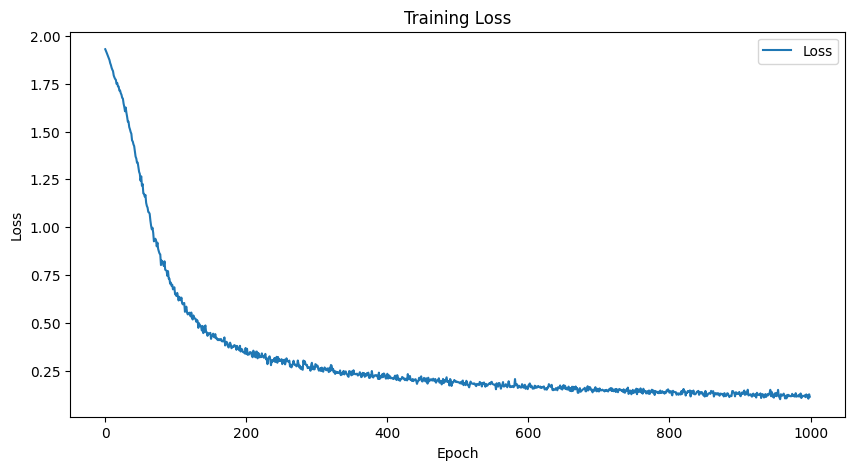

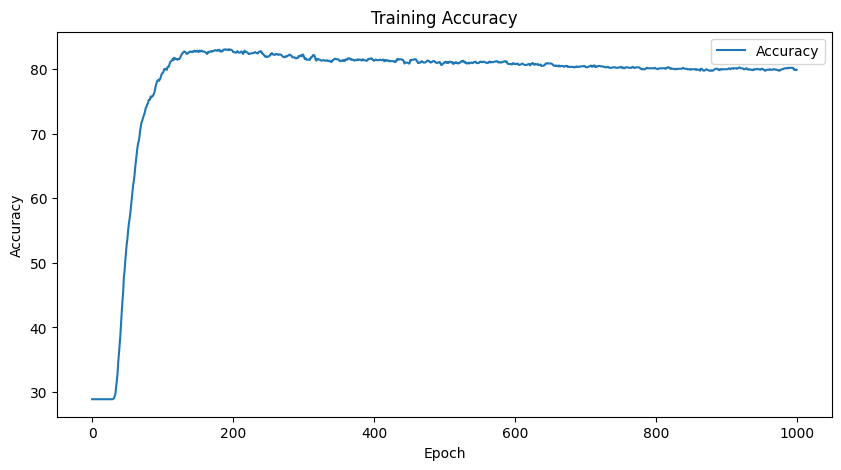

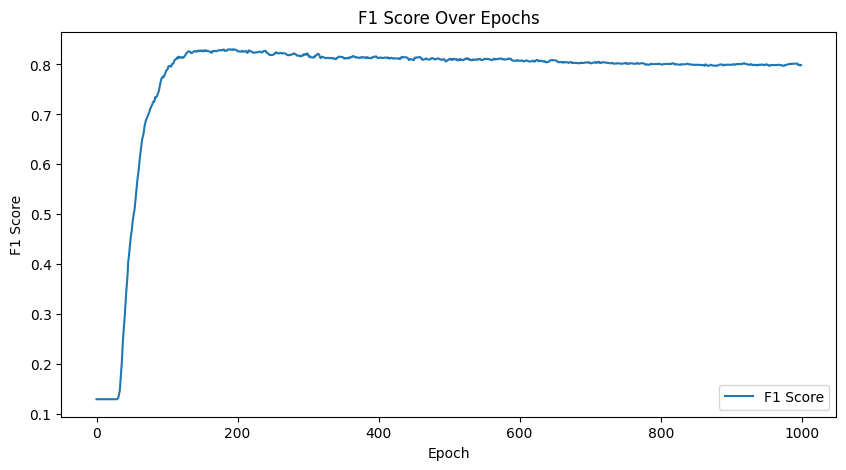

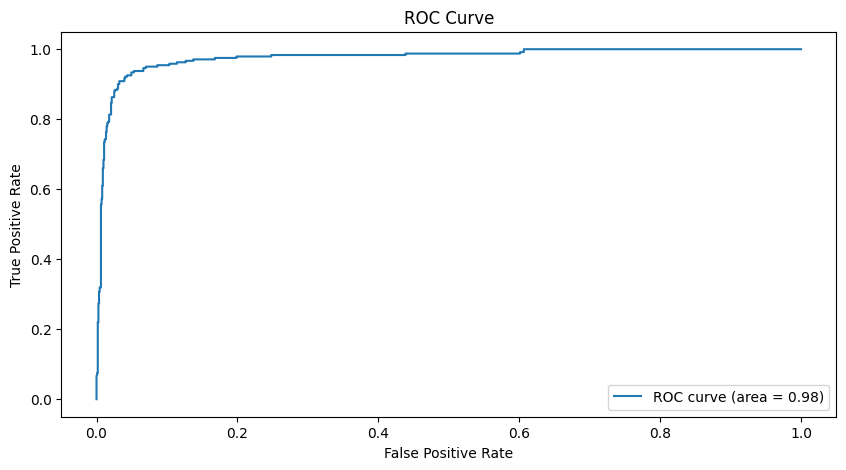

Accuracy: 79.91%


In [19]:
if __name__ == '__main__':
    # 定义当前设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"device: {device}")
    # 读取数据，得到样本的特征，标签和邻接矩阵
    data_path = './data/cora/'
    features, labels, adj = load_cora_data(data_path)
    print(f"features: {features.shape}")
    print(f"labels: {labels.shape}")
    print(f"adj: {adj.shape}")
    
    features = features.to(device)
    labels = labels.to(device)
    adj = adj.to(device)
    assert len(features) == len(labels)
    assert len(features) == len(adj)
    
    sample_num = features.shape[0]
    # 使用50%的数据作为训练集
    train_num = int(sample_num * 0.5)
    # 使用剩下的数据作为验证集
    test_num = sample_num - train_num
    print(f"train_num: {train_num}")
    print(f"test_num: {test_num}")
    
    features_num = features.shape[1]
    hidden_size = 16
    class_num = labels.max().item() + 1 # 样本的类别数
    dropout = 0.5
    print(f"features_num: {features_num}")
    print(f"hidden_size: {hidden_size}")
    print(f"class_num: {class_num}")
    
    # 创建GCN模型
    model = GCN(features_num, hidden_size, class_num, dropout).to(device)
    model.train()
    
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # 创建 TensorBoard 记录器
    writer = SummaryWriter(log_dir='./logs')
    
    n_epochs = 1000
    losses = []
    accuracies = []
    f1_scores = []
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        '''
       前向传播：：
        GCN的前向传播结点需要计算图中所有结点特征
        将features和adj全部传入model，得到输出
       '''
        outputs = model(features, adj)
        '''每个节点的特征更新不仅仅依赖于自己的特征，还依赖于邻居节点的特征
        所以即便不在训练集中，也要计算所有节点的输出，要当成是一个整体'''
        loss = criterion(outputs[:train_num], labels[:train_num])
        loss.backward()
        optimizer.step()
        
        # 记录损失到 TensorBoard
        writer.add_scalar('Loss/train', loss.item(), epoch)
        
        # 计算准确率和F1得分
        model.eval()
        with torch.no_grad():
            outputs = model(features, adj)
            predicted = torch.argmax(outputs[train_num:], dim=1)
            correct = (predicted == labels[train_num:]).sum().item()
            accuracy = 100 * correct / test_num
            f1 = f1_score(labels[train_num:].cpu(), predicted.cpu(), average='weighted')
        
        model.train()
        
        # 记录准确率和F1得分
        writer.add_scalar('Accuracy/train', accuracy, epoch)
        writer.add_scalar('F1_Score/train', f1, epoch)
        
        losses.append(loss.item())
        accuracies.append(accuracy)
        f1_scores.append(f1)
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{n_epochs} Loss: {loss.item()} Accuracy: {accuracy:.2f}% F1 Score: {f1:.2f}')
    
    # 保存模型权重
    torch.save(model.state_dict(), 'gcn_model.pth')
    
    # 计算ROC曲线
    with torch.no_grad():
        outputs = model(features, adj)
        probabilities = torch.softmax(outputs[train_num:], dim=1)
        fpr, tpr, _ = roc_curve(labels[train_num:].cpu().numpy(), probabilities[:, 1].cpu().numpy(), pos_label=1)
        roc_auc = auc(fpr, tpr)
    
    writer.close()
    
    # 分别绘制所有指标
    plot_loss(losses)
    plot_accuracy(accuracies)
    plot_f1_score(f1_scores)
    plot_roc_curve(roc_auc, fpr, tpr)

    print(f'Accuracy: {accuracy:.2f}%')

In [20]:
# 加载权重文件的测试函数
def test_model(model_path, data_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    features, labels, adj = load_cora_data(data_path)
    
    features = features.to(device)
    labels = labels.to(device)
    adj = adj.to(device)
    
    features_num = features.shape[1]
    hidden_size = 16
    class_num = labels.max().item() + 1
    dropout = 0.5
    
    model = GCN(features_num, hidden_size, class_num, dropout).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    with torch.no_grad():
        outputs = model(features, adj)
        predicted = torch.argmax(outputs, dim=1)
        accuracy = (predicted == labels).sum().item() / len(labels)
    
    print(f'Test Accuracy: {accuracy:.2f}%')

In [21]:
# 调用测试函数
test_model('gcn_model.pth', './data/cora/')

Loading cora data...
node_num: 2708
idx_map: {31336: 0, 1061127: 1, 1106406: 2, 13195: 3, 37879: 4, 1126012: 5, 1107140: 6, 1102850: 7, 31349: 8, 1106418: 9, 1123188: 10, 1128990: 11, 109323: 12, 217139: 13, 31353: 14, 32083: 15, 1126029: 16, 1118017: 17, 49482: 18, 753265: 19, 249858: 20, 1113739: 21, 48766: 22, 646195: 23, 1126050: 24, 59626: 25, 340299: 26, 354004: 27, 242637: 28, 1106492: 29, 74975: 30, 1152272: 31, 100701: 32, 66982: 33, 13960: 34, 13966: 35, 66990: 36, 182093: 37, 182094: 38, 13972: 39, 13982: 40, 16819: 41, 273152: 42, 237521: 43, 1153703: 44, 32872: 45, 284025: 46, 218666: 47, 16843: 48, 1153724: 49, 1153728: 50, 158098: 51, 8699: 52, 1134865: 53, 28456: 54, 248425: 55, 1112319: 56, 28471: 57, 175548: 58, 696345: 59, 28485: 60, 1139195: 61, 35778: 62, 28491: 63, 310530: 64, 1153784: 65, 1481: 66, 1153786: 67, 13212: 68, 1111614: 69, 5055: 70, 4329: 71, 330148: 72, 1105062: 73, 4330: 74, 5062: 75, 4335: 76, 158812: 77, 40124: 78, 1103610: 79, 688361: 80, 302545: